In [2]:
import warnings
warnings.simplefilter("ignore")

import numpy as np
import numpy.linalg as LA
from scipy import optimize
from maxvolpy.maxvol import rect_maxvol, maxvol
import matplotlib.pyplot as plt
from numba import jit, prange
from tqdm import tqdm

import grad_log_det as log_det
import gen_mat as gen
from mva_test import test_points_gen

%matplotlib inline

In [3]:
tol = 1e-12

# This is log-det of A.T@A
def D_optimality(A):
    S = LA.svd(A, compute_uv=False)
    S[S < tol] = tol
    ld = 2.0*np.sum(np.log(S))
    return ld

In [4]:
def log_det_update(current_inv, current_det, new_row):
    updated_det = current_det + np.log((1+new_row@current_inv@new_row.T))
    return updated_det
    
def inv_update(current_inv, new_row):
    updated_inv = current_inv - (1/(1+new_row@current_inv@new_row.T))*(current_inv@new_row.T)@new_row@current_inv
    return updated_inv

In [5]:
# This is with fast rank-1 update of determinant and matrix inverse

@jit(parallel=True, nogil = True)
def Algorithm_1_fast(A, N, criterion):
    N_candidate, P = A.shape
    I = []
    J = []
    current_inv = 1
    current_det = 1
    for n in range(N):
        if n < P:
            J.append(n) 
        
        if n >= P:
            current_max = -np.inf
            i_cand = 0
            for i in list(set(range(N_candidate)) - set(I)):
                I.append(i)
                current_d = log_det_update(current_inv, current_det, A[i,:].reshape(1,-1))
                if current_d > current_max:
                    current_max = current_d
                    i_cand = I.pop()
                    continue
                I.pop()
            I.append(i_cand)
            current_inv = inv_update(current_inv, A[i_cand,:].reshape(1,-1))
            current_det = current_max
            continue
            
        
        current_max = -np.inf
        i_cand = 0
        for i in list(set(range(N_candidate)) - set(I)):
            I.append(i)
            current_d = criterion(A[np.ix_(I, J)])      
            if current_d > current_max:
                current_max = current_d
                i_cand = I.pop()
                continue
            I.pop()
        I.append(i_cand)
        
        if n == P-1:
            current_inv = LA.inv(A[np.ix_(I, J)].T@A[np.ix_(I, J)])
            current_det = criterion(A[np.ix_(I, J)])
    return I

In [6]:
# This is slow version WITHOUT rank-1 updates
@jit(parallel=True, nogil = True)
def Algorithm_1(A, N, criterion):
    N_candidate, P = A.shape
    I = []
    J = []
    for n in range(N):
        if n < P:
            J.append(n)
        current_max = -np.inf
        i_cand = 0
        for i in list(set(range(N_candidate)) - set(I)):
            I.append(i)
            current_d = criterion(A[np.ix_(I, J)])
            if current_d > current_max:
                current_max = current_d
                i_cand = I.pop()
                continue
            I.pop()
        I.append(i_cand)
    return I

In [7]:
def GD_points(num_col=50, num_points=54, num_tries=1, interval=(-1.0,1.0), poly=gen.legendre):
    log_det.num_col = num_col
    log_det.dim = dim  
    bnds = (interval,) * (dim*num_points)
    dstrs = ['LHS']
        
    loss_f = lambda x: log_det.loss_func(x, poly=poly, ToGenDiff=False)
    loss_grad = lambda x: log_det.grad(x, poly=poly)
    res = np.inf
    for distrib in dstrs:
        for _ in range(num_tries):
            x_0 = test_points_gen(num_points, dim, interval=interval, distrib=distrib) # starting point of GD
            x_0 = x_0.ravel('F')
            op = optimize.fmin_l_bfgs_b(loss_f, x_0, fprime = loss_grad, factr = 10.0, bounds = bnds)
            res_cur = op[1]
            if res_cur < res:
                res = res_cur
                pnts = op[0]
            
    pnts = pnts.reshape(pnts.size//dim, dim, order="F")             
    return pnts

In [8]:
def error(f, f_tilda):
    return LA.norm(f-f_tilda,2)/LA.norm(f,2)

In [9]:
def rhs(A, c, noise=False):
    if noise:
        return A@c + 0.03*abs(A@c)*np.random.randn(A.shape[0],1) 
    return A@c

In [13]:
def lstsq_weighted(A, rhs, w):
    assert A.shape[0] == len(w) == len(rhs), "Dimenstion mismatch"
    #print("Initilal shape A: {}".format(A.shape))
    #print("Initilal shape rhs: {}".format(rhs.shape))
    A = (A.T*w).T
    rhs = (rhs.T*w).T
    #print("Ending shape A: {}".format(A.shape))
    #print("Ending shape rhs: {}".format(rhs.shape))
    #print("shape w: {}".format(w.shape))
    
    return LA.lstsq(A, rhs, rcond=-1)[0]

def Legendre_wt(x):
    num_pnts = x.shape[0]
    d = x.shape[1]
    ret = np.ones(num_pnts)
    for pnt in range(num_pnts):
        for i in range(d):
            ret[pnt] *= (1.0 - x[pnt, i]**2)**0.25
            
    return ret
        

In [16]:
np.random.seed(33)

Nc_N_ratio = 4


p = 2
d = 2
dim = d
interval = (-1.,1.)
P = gen.binom_sh(p=p,l=d)
N_div_P = np.arange(1,11)

c_true = np.array([np.random.randn() for x in range(P)]).reshape((-1,1))

errors = []
errors_al = []

for N in N_div_P:
    N = N*P
    N_c = Nc_N_ratio*N
    
    errors_maxvol = []
    errors_gd = []
    errors_algo = []

    for i in tqdm(range(60)):
        pnts_test = test_points_gen(int(1e4), d, interval=interval, distrib='random')
        Phi_test = gen.GenMat(P, pnts_test, poly=gen.legendre, ToGenDiff=False)
        rhs_test = rhs(Phi_test, c_true)
              
        pnts = test_points_gen(N_c, d, interval=interval, distrib='random')
        Phi_c = gen.GenMat(P, pnts, poly=gen.legendre, ToGenDiff=False)

#         points_GD = GD_points(num_col=P, num_points=N, num_tries=1, interval=(-1.0,1.0), poly=gen.legendre)
        
        rows_maxvol,_ = rect_maxvol(Phi_c, tol = 1.01, minK = N, maxK = N)
        rows_algo = Algorithm_1_fast(Phi_c, N, D_optimality)

        f_train_maxvol = rhs(Phi_c[rows_maxvol],c_true,noise=True)
#         f_train_gd = rhs(gen.GenMat(P, points_GD, poly=gen.legendre, ToGenDiff=False),c_true,noise=True)
        f_train_algo = rhs(Phi_c[rows_algo],c_true,noise=True)

        c_approx_maxvol = LA.lstsq(Phi_c[rows_maxvol], f_train_maxvol, rcond=-1)[0]
#         c_approx_gd = LA.lstsq(gen.GenMat(P, points_GD, poly=gen.legendre, ToGenDiff=False), f_train_gd, rcond=-1)[0]
        c_approx_algo = LA.lstsq(Phi_c[rows_algo], f_train_algo, rcond=-1)[0]
        
        # Uncomment for LHS
#         pnts = test_points_gen(N, d, interval=interval, distrib='LHS')
#         Phi_c = gen.GenMat(P, pnts, poly=gen.legendre, ToGenDiff=False)
#         f_train_maxvol = rhs(Phi_c,c_true,noise=True)
#         c_approx_maxvol = LA.lstsq(Phi_c, f_train_maxvol, rcond=-1)[0]

        errors_maxvol.append(error(rhs_test, Phi_test@c_approx_maxvol) <= 0.02)
#         errors_gd.append(error(rhs_test, Phi_test@c_approx_gd) <= 0.02)
        errors_algo.append(error(rhs_test, Phi_test@c_approx_algo) <= 0.02)
#     print(mean(errors_maxvol), std(errors_maxvol))
    errors.append(sum(errors_maxvol)/len(errors_maxvol))
#     errors_al.append(sum(errors_gd)/len(errors_gd))
    errors_al.append(sum(errors_algo)/len(errors_algo))

100%|██████████| 60/60 [00:14<00:00,  4.28it/s]


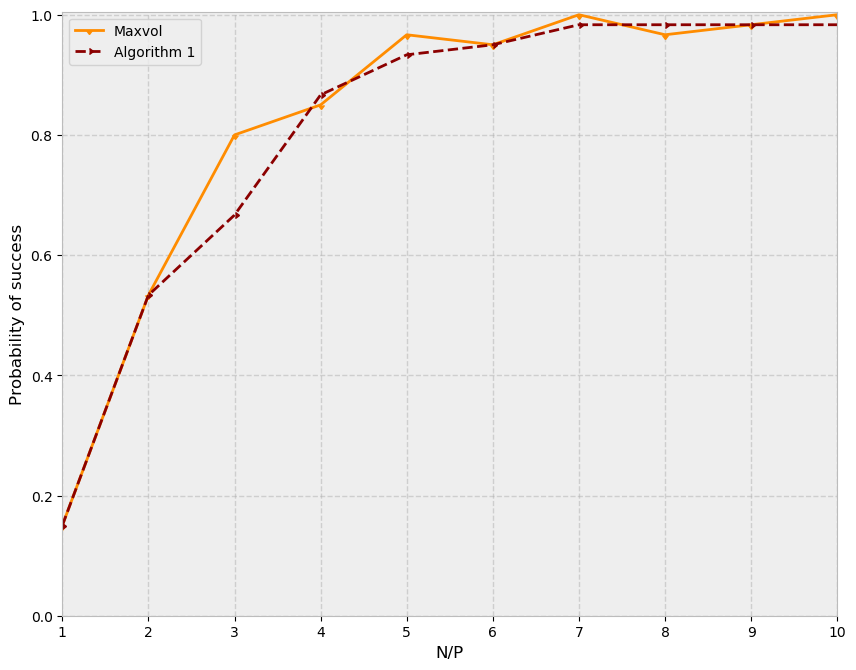

In [17]:
# Nc_N_ratio = 4
plt.figure(figsize=(10,8), dpi=100)

plt.plot(N_div_P, errors, 'darkorange', marker=11, label='Maxvol')
plt.plot(N_div_P, errors_al, 'darkred', marker=9, label='Algorithm 1')
plt.xlabel('N/P')
plt.ylabel('Probability of success')
plt.xlim(1,10)
plt.ylim(0,1.005)
plt.legend()
plt.show()

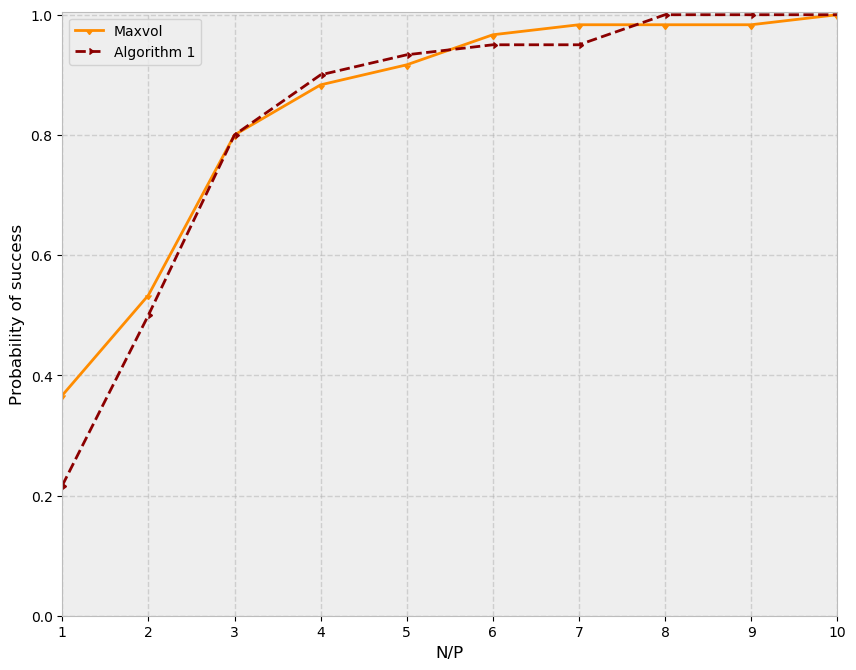

In [15]:
# Nc_N_ratio = 1000
plt.figure(figsize=(10,8), dpi=100)

plt.plot(N_div_P, errors, 'darkorange', marker=11, label='Maxvol')
plt.plot(N_div_P, errors_al, 'darkred', marker=9, label='Algorithm 1')
plt.xlabel('N/P')
plt.ylabel('Probability of success')
plt.xlim(1,10)
plt.ylim(0,1.005)
plt.legend()
plt.show()

# Compare only MaxVols

In [33]:
np.random.seed(42)

Nc_N_ratios = [4, 100, 10000]
num_tests = 200

p = 2
d = 2
dim = d
interval = (-1.,1.)
P = gen.binom_sh(p=p,l=d)
N_div_P = np.arange(1,11)

c_true = np.array([np.random.randn() for x in range(P)]).reshape((-1,1))

errors = dict()
for Nc in Nc_N_ratios:
    errors[Nc] = []


for N in N_div_P:
    N = N*P
    #N_c = Nc_N_ratio*N
    
    errors_maxvol = dict()
    for Nc in Nc_N_ratios:
        errors_maxvol[Nc] = []

    for i in tqdm(range(num_tests)):
        pnts_test = test_points_gen(int(1e4), d, interval=interval, distrib='random')
        Phi_test = gen.GenMat(P, pnts_test, poly=gen.legendre, ToGenDiff=False)
        rhs_test = rhs(Phi_test, c_true)
              
        for Nc in Nc_N_ratios:
            N_c = Nc*N
            pnts = test_points_gen(N_c, d, interval=interval, distrib='random')
            Phi_c = gen.GenMat(P, pnts, poly=gen.legendre, ToGenDiff=False)

#         points_GD = GD_points(num_col=P, num_points=N, num_tries=1, interval=(-1.0,1.0), poly=gen.legendre)
        
            rows_maxvol,_ = rect_maxvol(Phi_c, tol = 1.01, minK = N, maxK = N)
            #rows_algo = Algorithm_1_fast(Phi_c, N, D_optimality)

            f_train_maxvol = rhs(Phi_c[rows_maxvol],c_true,noise=True)
#         f_train_gd = rhs(gen.GenMat(P, points_GD, poly=gen.legendre, ToGenDiff=False),c_true,noise=True)
            #f_train_algo = rhs(Phi_c[rows_algo],c_true,noise=True)

            c_approx_maxvol = LA.lstsq(Phi_c[rows_maxvol], f_train_maxvol, rcond=-1)[0]
        
#         c_approx_gd = LA.lstsq(gen.GenMat(P, points_GD, poly=gen.legendre, ToGenDiff=False), f_train_gd, rcond=-1)[0]
            #c_approx_algo = LA.lstsq(Phi_c[rows_algo], f_train_algo, rcond=-1)[0]
        
        # Uncomment for LHS
#         pnts = test_points_gen(N, d, interval=interval, distrib='LHS')
#         Phi_c = gen.GenMat(P, pnts, poly=gen.legendre, ToGenDiff=False)
#         f_train_maxvol = rhs(Phi_c,c_true,noise=True)
#         c_approx_maxvol = LA.lstsq(Phi_c, f_train_maxvol, rcond=-1)[0]

            errors_maxvol[Nc].append(error(rhs_test, Phi_test@c_approx_maxvol) <= 0.02)
#         errors_gd.append(error(rhs_test, Phi_test@c_approx_gd) <= 0.02)
            #errors_algo[Nc].append(error(rhs_test, Phi_test@c_approx_algo) <= 0.02)
#     print(mean(errors_maxvol), std(errors_maxvol))
    for Nc in Nc_N_ratios:
        errors[Nc].append(sum(errors_maxvol[Nc])/len(errors_maxvol[Nc]))
#     errors_al.append(sum(errors_gd)/len(errors_gd))
    #errors_al.append(sum(errors_algo)/len(errors_algo))

100%|██████████| 200/200 [13:25<00:00,  4.03s/it]


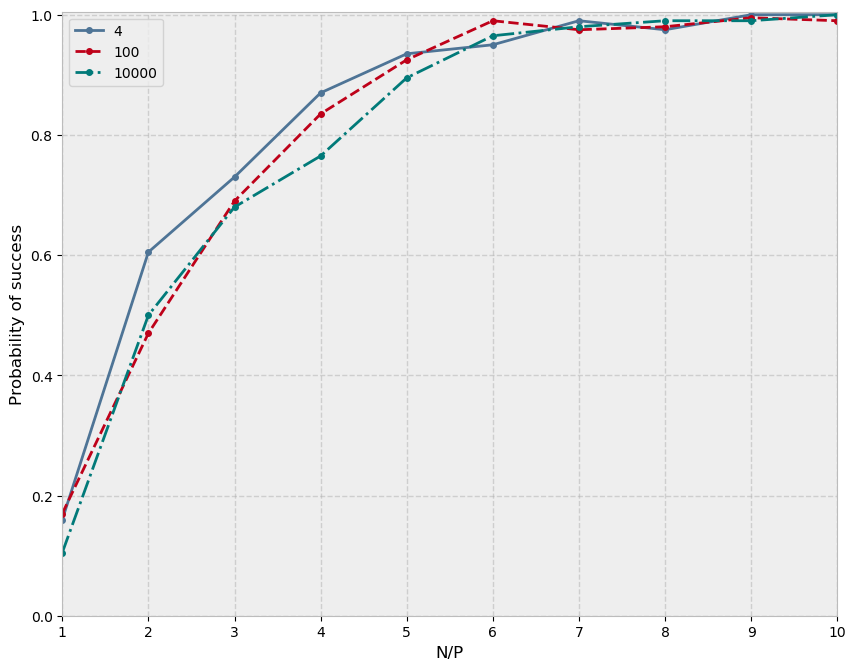

In [34]:
plt.figure(figsize=(10,8), dpi=100)

for Nc in Nc_N_ratios:
    plt.plot(N_div_P, errors[Nc], label=str(Nc))
plt.xlabel('N/P')
plt.ylabel('Probability of success')
plt.xlim(1,10)
plt.ylim(0,1.005)
plt.legend()
plt.show()

# wighted MaxVol

In [20]:
np.random.seed(33)

Nc_N_ratio = 4
num_tests = 5000
#num_tests = 1
num_test_pnts = int(1e4)


p = 2
d = 2
dim = d
interval = (-1.,1.)
P = gen.binom_sh(p=p,l=d)
N_div_P = np.arange(1,11)

c_true = np.array([np.random.randn() for x in range(P)]).reshape((-1,1))

errors = []
errors_wt = []

for N in N_div_P:
    N = N*P
    N_c = Nc_N_ratio*N
    
    errors_maxvol = []
    errors_maxvol_wt = []

    for i in tqdm(range(num_tests)):
        pnts_test = test_points_gen(num_test_pnts, d, interval=interval, distrib='random')
        Phi_test = gen.GenMat(P, pnts_test, poly=gen.legendre, ToGenDiff=False)
        rhs_test = rhs(Phi_test, c_true)
              
        pnts = test_points_gen(N_c, d, interval=interval, distrib='random')
        Phi_c = gen.GenMat(P, pnts, poly=gen.legendre, ToGenDiff=False)

#         points_GD = GD_points(num_col=P, num_points=N, num_tries=1, interval=(-1.0,1.0), poly=gen.legendre)
        
        rows_maxvol,_ = rect_maxvol(Phi_c, tol = 1.01, minK = N, maxK = N)

        f_train_maxvol = rhs(Phi_c[rows_maxvol], c_true, noise=True)

        c_approx_maxvol = LA.lstsq(Phi_c[rows_maxvol], f_train_maxvol, rcond=-1)[0]
        #print(c_approx_maxvol.shape)
        
        wt = Legendre_wt(pnts[rows_maxvol])
        c_approx_maxvol_wt = lstsq_weighted(Phi_c[rows_maxvol], f_train_maxvol, wt)
        #print(c_approx_maxvol_wt.shape)
        
        # Uncomment for LHS
#         pnts = test_points_gen(N, d, interval=interval, distrib='LHS')
#         Phi_c = gen.GenMat(P, pnts, poly=gen.legendre, ToGenDiff=False)
#         f_train_maxvol = rhs(Phi_c,c_true,noise=True)
#         c_approx_maxvol = LA.lstsq(Phi_c, f_train_maxvol, rcond=-1)[0]

        errors_maxvol.append(error(rhs_test, Phi_test@c_approx_maxvol) <= 0.02)
#         errors_gd.append(error(rhs_test, Phi_test@c_approx_gd) <= 0.02)
        errors_maxvol_wt.append(error(rhs_test, Phi_test@c_approx_maxvol_wt) <= 0.02)
#     print(mean(errors_maxvol), std(errors_maxvol))
    errors.append(sum(errors_maxvol)/len(errors_maxvol))
#     errors_al.append(sum(errors_gd)/len(errors_gd))
    errors_wt.append(sum(errors_maxvol_wt)/len(errors_maxvol_wt))

100%|██████████| 5000/5000 [00:24<00:00, 201.22it/s]


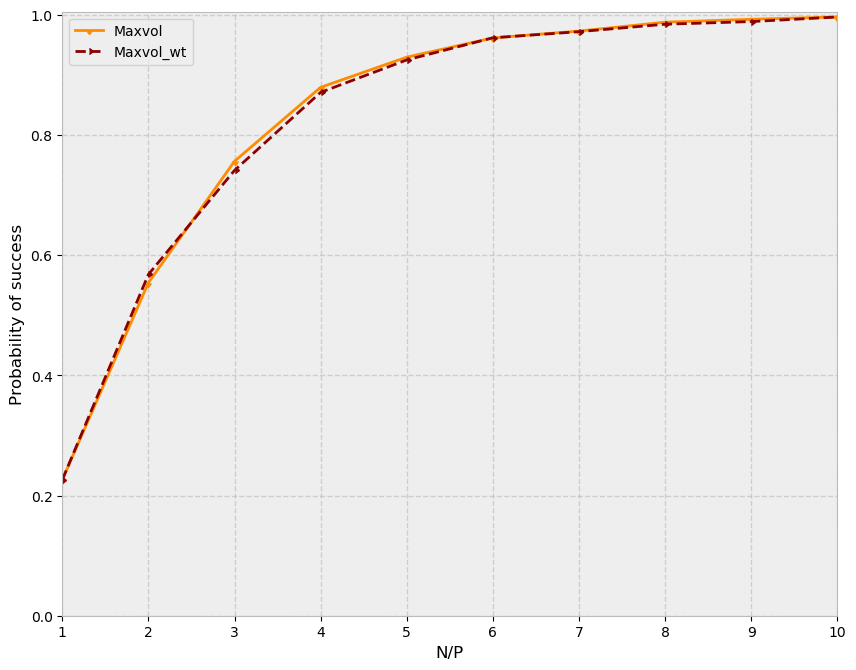

In [21]:
# Nc_N_ratio = 1000
plt.figure(figsize=(10,8), dpi=100)

plt.plot(N_div_P, errors, 'darkorange', marker=11, label='Maxvol')
plt.plot(N_div_P, errors_wt, 'darkred', marker=9, label='Maxvol_wt')
plt.xlabel('N/P')
plt.ylabel('Probability of success')
plt.xlim(1,10)
plt.ylim(0,1.005)
plt.legend()
plt.show()